In [18]:
import re
import numpy as np
from regex import R
# Read responses
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pylab as plt
import seaborn as sns
from ast import literal_eval

custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom":
    False,"lines.linewidth": 2, "grid.color": "lightgray", "legend.frameon": False, "xtick.labelcolor": "#484848", "ytick.labelcolor":
    "#484848", "xtick.color": "#484848", "ytick.color": "#484848","text.color": "#484848", "axes.labelcolor": "#484848",
    "axes.titlecolor":"#484848","figure.figsize": [5,3],
    "axes.titlelocation":"left","xaxis.labellocation":"left","yaxis.labellocation":"bottom"}
palette = ["#3d348b","#e6af2e","#191716","#e0e2db"] #use your favourite colours
sns.set_theme(context='paper', style='white', palette=palette, font='Verdana', font_scale=1.3, color_codes=True,
rc=custom_params)


path_figures = "/Users/garci061/Dropbox/Apps/Overleaf/2022_rumor_final/Figures/"
path_data = "../data/data_raw/"



In [10]:

def word_tokenize(text):
    """Return a list of words from a string"""
    return re.findall(r'\w+', text)

def text_similarity_word(one,two):
    if isinstance(two, float):
        return 0
    """Return the Jaccard similarity between two strings at the word level removing stopwords"""
    stopwords = {"couldn't", "you're", 'same', 'she', 'so', 'hers', 'being', "you'll", 'more', 'those', 'm', "shan't", 've', 'hadn', 'up', 'her', "wasn't", 'herself', 'are', 'at', 'while', 'can', 'few', 'them', 'yourselves', 'its', 'i', 'we', 'yourself', 'nor', 'couldn', 'it', 'were', 'll', 'ain', "mightn't", "wouldn't", 'the', 'after', 'ma', "hadn't", 're', 'is', 'had', 'until', "didn't", 'themselves', 'd', "haven't", 'they', 'their', "won't", 's', 'didn', "needn't", 'through', 'or', 'needn', 'won', 'that', 'who', 'over', 'some', 'not', 'against', 'down', 'above', 'your', 'how', 'isn', 'once', 'ourselves', 'a', 'to', 'between', 'his', 'shouldn', 'why', 'hasn', 'doing', 'no', 'before', 'now', 'very', 'wasn', 'he', "you'd", "don't", 'further', 'itself', 'other', 'whom', 'these', 'mightn', 'o', 'do', 'when', 'because', 'where', 'into', 'each', 'on', 't', "she's", "it's", "weren't", 'did', 'just', 'out', 'which', 'wouldn', 'this', 'shan', 'below', 'too', "should've", 'mustn', 'during', 'doesn', 'both', "doesn't", 'as', 'my', 'him', 'weren', "that'll", 'what', 'ours', 'himself', 'under', "aren't", 'theirs', 'for', 'most', "shouldn't", 'than', 'y', 'yours', 'will', 'any', 'me', 'here', 'off', 'if', 'has', 'with', 'and', 'does', 'again', "mustn't", 'in', 'be', 'having', 'about', 'was', 'only', 'such', 'don', 'am', 'have', 'own', 'of', "you've", 'from', 'by', 'all', 'but', 'our', 'should', 'haven', "hasn't", 'an', "isn't", 'there', 'been', 'aren', 'then', 'you', 'myself'}
    
    # Remove punctuation
    #one = re.sub(r'[^\w\s]','',one)
    #two = re.sub(r'[^\w\s]','',two)

    # Tokenize word
    one = word_tokenize(one.lower())
    two = word_tokenize(two.lower())
    set1 = set(one) - stopwords
    set2 = set(two) - stopwords
    return len(set1.intersection(set2))/len(set1.union(set2))#*np.log10(len(set1))*np.log10(len(set2))
    


def text_similarity(one, two):
    """Return a measure of the similarity between two texts"""
    if isinstance(two, float):
        return 0
    from Levenshtein import ratio
    return ratio(one, two)*np.log10(len(one))*np.log10(len(two))

def text_similarity_difflib(one, two):
    """Return a measure of the similarity between two texts"""
    if isinstance(two, float):
        return 0
    #from Levenshtein import ratio
    from difflib import SequenceMatcher
    ratio = lambda x, y: SequenceMatcher(None, x, y).ratio()
    return ratio(one, two)#*np.log10(len(one))*np.log10(len(two))


def text_similarity_lower(one, two):
    """Return a measure of the similarity between two texts"""
    if isinstance(two, float):
        return 0
    from Levenshtein import ratio, distance
    # from difflib import SequenceMatcher
    # ratio = lambda x, y: SequenceMatcher(None, x, y).ratio()
    return ratio(one.lower(), two.lower())#*np.log10(len(one))*np.log10(len(two))



In [11]:

def read_data(chain, network=True):

    if network:
        for i in range(3):
            chain[f"input{i}"] = chain["read_stories"].apply(literal_eval).str[i]
            bool_ = chain[f"input{i}"].apply(lambda x: isinstance(x,float))
            chain.loc[bool_, f"input{i}"] = chain.loc[bool_, "input0"]
            chain[f"current_distance{i}"] = chain.apply(lambda x: text_similarity_lower(x[f"input{i}"], x["response"]), axis=1)
            chain[f"proposed_distance{i}"] = chain.apply(lambda x: text_similarity_word(x[f"input{i}"], x["response"]), axis=1)

        chain["current_distance"] = chain[[f"current_distance{i}" for i in range(3)]].max(1)
        chain["proposed_distance"] = chain[[f"proposed_distance{i}" for i in range(3)]].max(1)


        chain["input"] = chain.apply(lambda x: x["input0"] if (len(x["input0"]) > len(x["input1"])) & (len(x["input0"]) > len(x["input2"])) 
                                                            else (x["input1"] 
                                                                    if (len(x["input1"]) > len(x["input2"]))
                                                                    else x["input2"]),
                                    axis=1)
        chain["input_r"] = "input"+chain[[f"current_distance{i}" for i in range(3)]].idxmax(1).str[-1]
        chain["input_r"] = chain.apply(lambda x: x[x["input_r"]], axis=1)
        
        chain["input_p"] = "input"+chain[[f"proposed_distance{i}" for i in range(3)]].idxmax(1).str[-1]
        chain["input_p"] = chain.apply(lambda x: x[x["input_p"]], axis=1)

    else:
        chain["input"] = chain["read_stories"].apply(eval).str[0]
        chain["current_distance"] = chain.apply(lambda x: text_similarity_lower(x["input"], x["response"]), axis=1)
        chain["proposed_distance"] = chain.apply(lambda x: text_similarity_word(x["input"], x["response"]), axis=1)
    return chain



In [20]:
def calculate_distance_sentence(s):
    if isinstance(s[1], float):
        return 0
    input,output = s
    input = [_ for _ in re.split("\. ?|\n", input)]
    output = [_ for _ in re.split("\. ?|\n", output)]
  
    # Levensthein similairty with each sentence in output
    dist = 0
    for sentence in output:
        sims = [text_similarity_lower(sentence, _) for _ in input]
        dist += max(sims)*len(sentence)

    return dist/len(s[1])

In [23]:
def accept(row):
    # Small input
    if len(row["input"]) < 150:
        if (row["similarity_sentence"] > 0.4):
            return "small_ok"
        else:
            return "sim_reject"

    else:
        if (row["similarity_sentence"] < 0.4) | \
            (row["similarity_sentence"] > 0.7):
            return "sim_reject"
        elif len(row["input"])==2920:
            if (row["current_distance"] > 0.4) | \
                (row["current_distance"] < 0.1):
                return "lev_reject"
            else:
                return "ok"

        elif (row["proposed_distance"] < 0.03):
            return "jac_reject"
        else:
            return "ok"
      
    

In [15]:
!mkdir figures_filtering

mkdir: figures_filtering: File exists


In [16]:
def create_figures(chain, network, type_="experiment"):
    # Calculate distances
    network["input_combined"] = network["input0"] + ". " + network["input1"] + ". " + network["input2"]
    network["similarity_sentence"] = network[["input_combined","response"]].apply(calculate_distance_sentence, axis=1)
    network["accept"] = network.apply(accept, axis=1)
    network["length_input"] = network["input"].str.len()
    network["length_response"] = network["response"].str.len()
    network[["input0","input1","input2","response","accept","length_input","length_response","current_distance","proposed_distance","similarity_sentence"]].to_csv("~/Downloads/network.csv",index=None)

    chain["similarity_sentence"] = chain[["input","response"]].apply(calculate_distance_sentence, axis=1)
    chain["accept"] = chain.apply(accept, axis=1)
    chain["length_input"] = chain["input"].str.len()
    chain["length_response"] = chain["response"].str.len()
    chain[["input","response","accept","length_input","length_response","current_distance","proposed_distance","similarity_sentence"]].to_csv("~/Downloads/chain.csv",index=None)


    chain["color"] = chain["accept"].apply(lambda x: "tomato" if "sim_reject" in x else ("black" if "reject" in x else "cornflowerblue"))
    network["color"] = network["accept"].apply(lambda x: "tomato" if "sim_reject" in x else ("black" if "reject" in x else "cornflowerblue"))

    plt.plot([150,2920],[0.7,0.7],"--", color="orange")
    # plt.plot([30,2920],[0.43,0.43],":", color="blue")
    # plt.plot([30,2920],[0.45,0.45],":", color="k")
    plt.plot([30,2920],[0.4,0.4],":", color="orange")

    plt.scatter(chain["length_input"],chain["similarity_sentence"], color=chain["color"], marker=".")
    plt.scatter(network["length_input"],network["similarity_sentence"], color=network["color"], marker="3")
    plt.xscale("log")
    plt.xlabel("Input length (characters)")
    plt.ylabel("Sentence similarity")
    plt.tight_layout()
    plt.savefig(f"{path_figures}/app_sentence_sim_{type_}.pdf")
    plt.show()


    chain["color"] = chain["accept"].apply(lambda x: "gray" if "sim_reject" in x else ("tomato" if "lev_reject" in x else ("black" if "reject" in x else "cornflowerblue")))
    network["color"] = network["accept"].apply(lambda x: "gray" if "sim_reject" in x else ("tomato" if "lev_reject" in x else ("black" if "reject" in x else "cornflowerblue")))


    plt.plot([2120,4520],[0.4,0.4], "--", color="orange", lw=2)
    plt.plot([2120,4520],[0.1,0.1], "--", color="orange", lw=2)

    plt.scatter(chain["length_input"]*(1+0.1*np.random.randn(len(chain))),chain["current_distance"], color=chain["color"], marker=".")
    plt.scatter(network["length_input"]*(1+0.1*np.random.randn(len(network))),network["current_distance"], color=network["color"], marker="3")
    plt.xlabel("Input length (characters)")
    plt.ylabel("Levensthein similarity")
    plt.xscale("log")
    plt.tight_layout()
    plt.savefig(f"{path_figures}/app_lev_sim_{type_}.pdf")
    plt.show()

    chain["color"] = chain["accept"].apply(lambda x: "gray" if x in ["sim_reject","lev_reject"] else ("tomato" if "jac_reject" in x else ("black" if "reject" in x else "cornflowerblue")))
    network["color"] = network["accept"].apply(lambda x: "gray" if x in ["sim_reject","lev_reject"] else ("tomato" if "jac_reject" in x else ("black" if "reject" in x else "cornflowerblue")))

    #plt.plot([150,2920],[1,0.4], color="orange")
    plt.plot([150,2920],[0.03,0.03], color="orange")
    #plt.plot([150,2920],[0.02,0.02], color="orange")
    plt.scatter(chain["length_input"]*(1+0.1*np.random.randn(len(chain))),chain["proposed_distance"], color=chain["color"], marker=".")
    plt.scatter(network["length_input"]*(1+0.1*np.random.randn(len(network))),network["proposed_distance"], color=network["color"], marker="3")

    plt.xscale("log")
    plt.xlabel("Input length (characters)")
    plt.ylabel("Jaccard similarity")
    plt.tight_layout()
    plt.savefig(f"{path_figures}/app_jacc_sim_{type_}.pdf")


# Pilot
(used to create the filters)

151 149


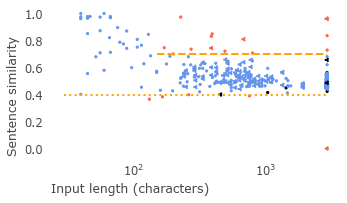

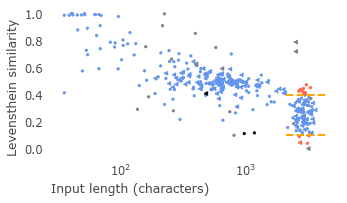

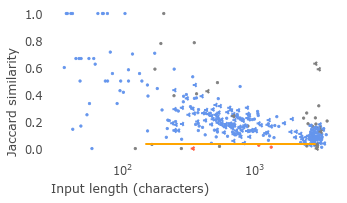

In [24]:
# Pilot data

chain = read_data(pd.read_csv(f"{path_data}/2021-chain-pilot.csv"), network=False)
network = read_data(pd.read_csv(f"{path_data}/2021-network-pilot.csv"), network=True)
print(len(chain), len(network))
create_figures(chain, network, type_="pilot")


# Experiment

265 732


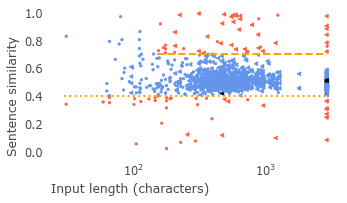

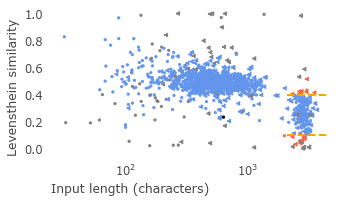

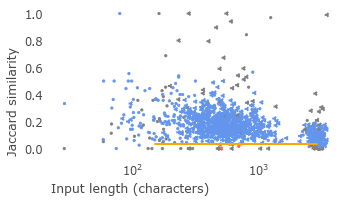

In [25]:


# Experiment data
info = pd.read_csv(f"{path_data}/37a1844f-b708-9e38-aed9-8582222000b8-data/data/info.csv", usecols=["origin_id", "failed", "contents"]).drop_duplicates()

def parse_response(cont):
    try:
        return literal_eval(cont)
    except:
        return ""
        
info["contents"] = info["contents"].apply(parse_response)
info = info.loc[info["contents"] != ""]
info = pd.concat([info[["failed", "origin_id"]], pd.DataFrame(info.contents.to_list())], axis=1)
info["response_accepted"] = info["failed"] == "f"
info["read_stories"] = info["read_stories"].astype(str)
info = info.loc[info["response"] != ""]

chain = read_data(info.loc[info["network_type"]=="chain"], network=False)
network = read_data(info.loc[info["network_type"]=="network"], network=True)
print(len(chain), len(network))
create_figures(chain, network, type_="experiment")